###### Dataset source = https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
###### Special thanks to https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python and https://www.kaggle.com/dfitzgerald3/randomforestregressor

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from scipy.stats import norm, skew

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data analysis

### Missing values

In [4]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data.head(30)

,total,percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


### Since they are many missing values, we need to find the relationship by doing correlation matrix

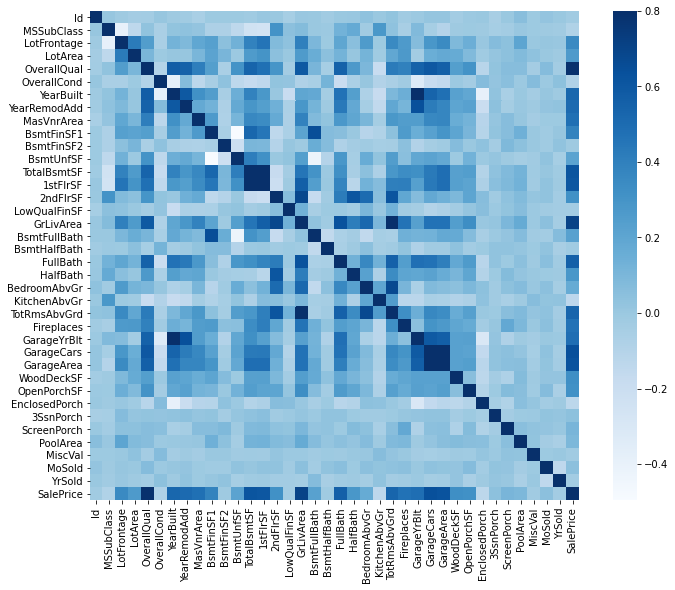

In [5]:
#lets plot heatmap for this
cormat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, vmax=.8, cmap="Blues", square=True);

First my attention got to the two red color dots, this refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs.

Another thing 'salesprice' got my attention as we can clearly see that 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' and many other variables are directly affecting the sales price. 

#### Now we will see salesprice corelation matrix (zoomed heatmap style)

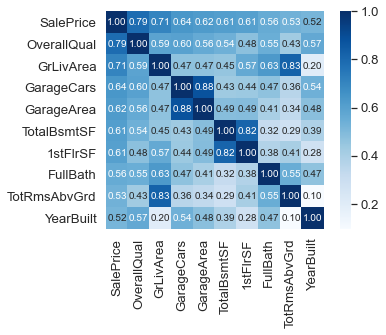

In [6]:
k = 10 #number of variables
cols = cormat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.20)
hm = sns.heatmap(cm, cmap='Blues', cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, xticklabels=cols.values, yticklabels=cols.values)

'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' bcoz total basement area is effective for sales price according to my view.
'FullBath' also seems usefull.
'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.
'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'.

The plot concerning 'SalePrice' and 'YearBuilt' can make us think. In the bottom of the 'dots cloud', we see what almost appears to be a like exponential function. We can also see this same tendency in the upper limit of the 'dots cloud'. Also, notice how the set of dots regarding the last years tend to stay above this limit.

# Feature Engineering

### Target variable salesprice

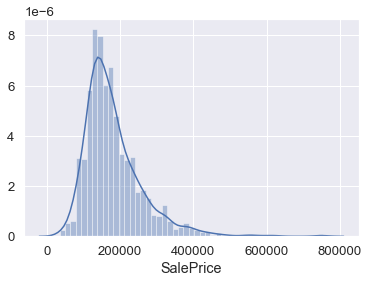

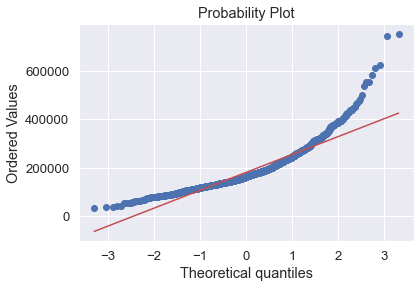

In [7]:
sns.distplot(df_train['SalePrice']);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, log transformations usually works well

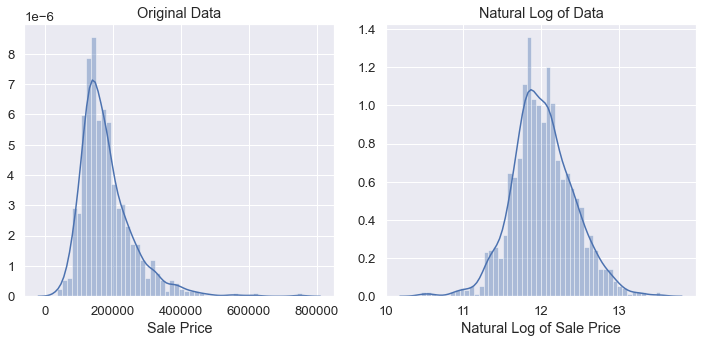

In [8]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### Outlier
Define Median Absolute Deviation Function
Function found in this link: http://stackoverflow.com/a/22357811/5082694

In [9]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


Merge Train and Test to evaluate ranges and missing values.

This was done primarily to ensure that Categorical data in the training and testing data sets were consistent.

In [10]:
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

### Find all categorical data

In [11]:
cats =[]
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)

#### Create separte datasets for Continuous vs Categorical
Creating two data sets allowed me to handle the data in more appropriate ways.

In [12]:
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]
df_cont.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [13]:
df_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### Handle Missing Data for continuous data
If any column contains more than 50 entries of missing data, drop the column.

If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column.

Remove outliers using Median Absolute Deviation.

Calculate skewness for each variable and if greater than 0.75 transform it and
apply the sklearn.Normalizer to each column.

In [14]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].values.reshape(1,-1))[0]

C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\

### Handle Missing Data for Categorical Data
If any column contains more than 50 entries of missing data, drop the column.

If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA' and 
apply the sklearn.LabelEncoder.

For each categorical variable determine the number of unique values and for each, create a new column that is binary

In [15]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

### Merge Numeric and Categorical Datasets and Create Training and Testing Data

In [17]:
df_new = df_cont.join(df_cat)
df_train = df_new.iloc[:len(df_train) -1]
df_train = df_train.join(target_log)
df_test = df_new.iloc[len(df_train)+1:]

X_train = df_train[df_train.columns.values[1:-1]]
y_train = df_train[df_train.columns.values[-1]]

X_test = df_test[df_test.columns.values[1:]]

# Prediction

##### Create Estimator and Apply Cross Validation
We can gauge the accuracy of our model by implementing an multi-fold cross validation and outputting the score. In this case I chose to run 15 iterations and output the score as Root Mean Squared Error.

C:\Users\91926\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass greater_is_better=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


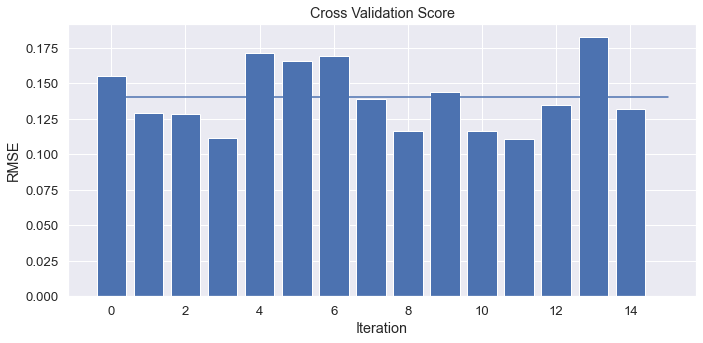

In [18]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=X_train, y=y_train, cv=15, scoring=scorer))
plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')
plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

## Visualize Predicted vs. Actual Sales Price
In order to visualize our predicted values vs our actual values we need to split our data into training and testing data sets. This can easily be accomplished using sklearn's train_test_split module.

We will train the model using a random sampling of our data set and then compare visually against the actual values.

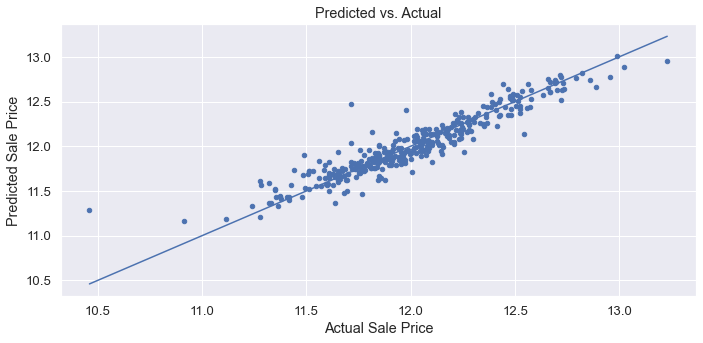

In [19]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [23]:
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test1, y_pred)))) 

Root Mean Square Error test = 0.12879507381391753
